# Klassifiziere Trainieren und Testen
In diesem Notebook wird das MobilenetV2 von Keras durch Transfer Learning auf den neuen Datensatz trainiert. Während des Training werden automatisch Performance-Ausgaben erzeugt, die Auskunft über die Identifikationsgenauigkeit liefer.

Der Code für das Transfer Learning ist in Anlehung an [dieses](https://pythontutorials.eu/deep-learning/transfer-learning/) Tutorial von Pythontutorials entwickelt worden, aber auf unseren Anwendungsfall zum Identifizieren von Kühen umgemüntzt. 

In [13]:
import numpy as np
import os

from keras.layers import Dense
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions

from keras import metrics
from keras.callbacks import Callback
from scikitplot.metrics import plot_confusion_matrix, plot_roc

import imageio.v2 as imageio 
from skimage.transform import resize

import matplotlib.pyplot as plt


## Bilder Laden
Ähnlich wie im ersten Notebook werden hier die Bilder einfach pro Ordner geladen und entweder in den Trainings oder den Testdatensatz einsortiert. Die Aufteilung ist so gelöst, dass jedes dritte Bild den Testdaten zugeordnet wird.

In [2]:
IMG_WIDTH   = 224
IMG_HEIGHT  = 224

IMGS_FOLDER = 'data/augment/'

train_data       = []
train_class_name = []
test_data        = []
test_class_name  = []

for img_dir in os.listdir(IMGS_FOLDER):
    img_index = 0
    for file_dir in os.listdir(os.path.join(IMGS_FOLDER, img_dir)):
        # Laden und vorbereiten des Bildes
        image_path = os.path.join(IMGS_FOLDER, img_dir,  file_dir)
        im = imageio.imread(image_path)
        im = preprocess_input(im)
        im = resize(im, output_shape=(IMG_WIDTH, IMG_HEIGHT))

        # Teilen in Training und Testing
        if (img_index % 3) != 0:
            train_data.append(im)
            train_class_name.append(img_dir)
        else:
            test_data.append(im)
            test_class_name.append(img_dir)

        img_index += 1

train_data = np.array(train_data)
test_data = np.array(test_data)

# print(train_data.shape)
# print(test_data.shape)

## Trainieren
Diese Callback-Klasse wurde dem Keras Metrics Tutorial von [Neptune.ai](https://neptune.ai/blog/keras-metrics) entnommen. Die Methode on_epoch_end erzeugt nach jeder durchlaufenen Epoche eine Confusion Matrix und eine ROC-Curve für jede Klasse im Datensatz. 

In [22]:
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]
        y_pred_class = np.argmax(y_pred, axis=1)

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.set_frameon(True)
        fig.set_facecolor('white')
        fig.savefig(os.path.join(self.image_dir, f'conf_mat_epoch_{epoch}'), bbox_inches='tight', transparent=False)

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.set_frameon(True)
        fig.set_facecolor('white')
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'), bbox_inches='tight', transparent=False)

Hier werden nun die Klassen des Datensatz so transformiert, dass sie von Keras verwendet werden können. Die Ordnernamen werden dabei auf Indizes von 0 bis 22 gemappt.

Danach wird das Model geladen, die Änderungen am Ausgabelayer vorgenommen und mit dem Trainingsdatensatz trainiert. Die Evaluation geschieht direkt beim Training durch das setzen des `validation_data`-Parameters in der `fit`-Methode. Durch den oben definierten Callback werden mit jeder Epoche die Trainingsfortschritte geplottet und als Bilddateien im Ordner Performance ausgegeben.  

Epoch 1/12
23/23 [==============================] - 10s 409ms/step
45/45 - 42s - loss: 2.0132 - accuracy: 0.4809 - val_loss: 0.9641 - val_accuracy: 0.8531 - 42s/epoch - 930ms/step
Epoch 2/12
23/23 [==============================] - 10s 413ms/step
45/45 - 39s - loss: 0.6085 - accuracy: 0.9435 - val_loss: 0.4606 - val_accuracy: 0.9492 - 39s/epoch - 874ms/step
Epoch 3/12
23/23 [==============================] - 10s 420ms/step
45/45 - 39s - loss: 0.2969 - accuracy: 0.9866 - val_loss: 0.2922 - val_accuracy: 0.9703 - 39s/epoch - 875ms/step
Epoch 4/12
23/23 [==============================] - 10s 420ms/step
45/45 - 39s - loss: 0.1840 - accuracy: 0.9936 - val_loss: 0.2209 - val_accuracy: 0.9732 - 39s/epoch - 875ms/step
Epoch 5/12
23/23 [==============================] - 10s 421ms/step
45/45 - 40s - loss: 0.1242 - accuracy: 0.9972 - val_loss: 0.1794 - val_accuracy: 0.9788 - 40s/epoch - 883ms/step
Epoch 6/12
23/23 [==============================] - 10s 413ms/step
45/45 - 40s - loss: 0.0931 - accu

C:\Users\Christian\AppData\Local\Temp\ipykernel_16512\3798776256.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 12))


45/45 - 39s - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.0865 - val_accuracy: 0.9915 - 39s/epoch - 856ms/step
Epoch 12/12
23/23 [==============================] - 10s 410ms/step
45/45 - 39s - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9915 - 39s/epoch - 875ms/step


C:\Users\Christian\AppData\Local\Temp\ipykernel_16512\1767898953.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


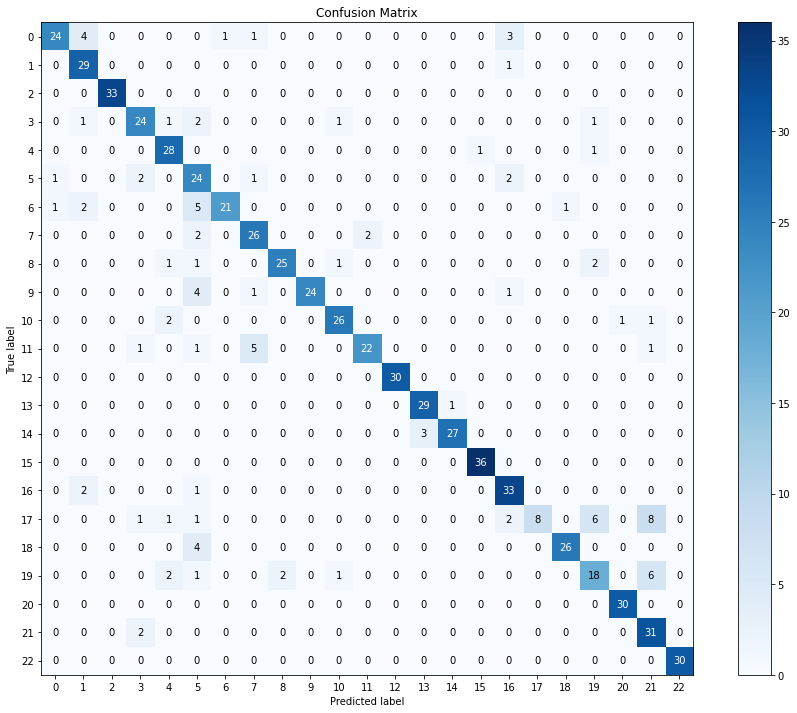

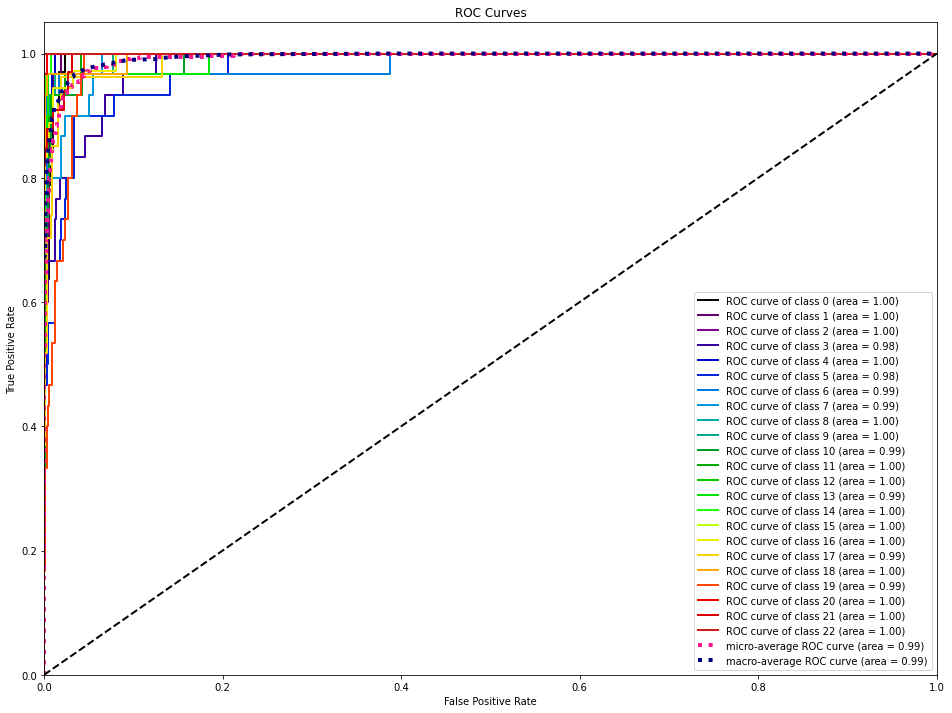

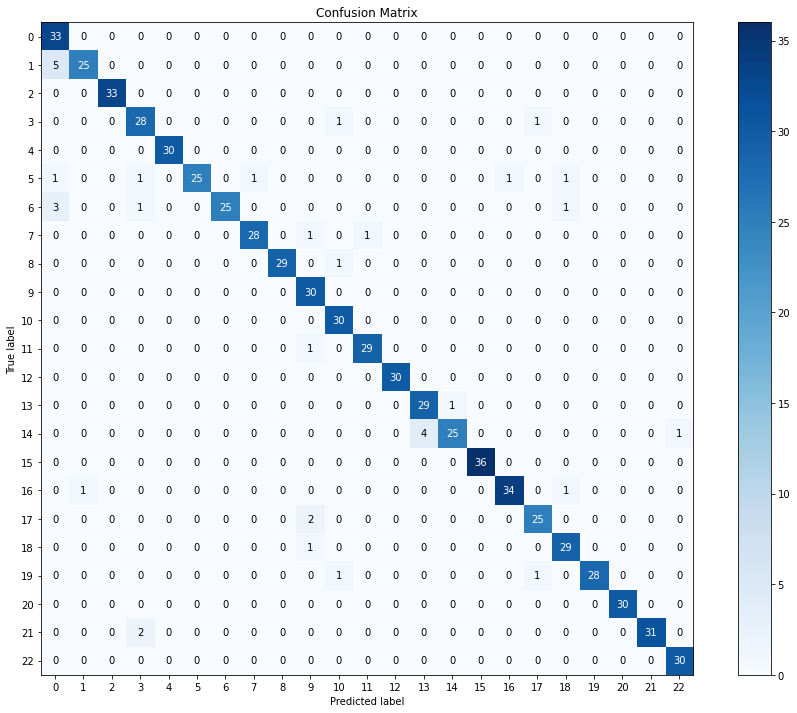

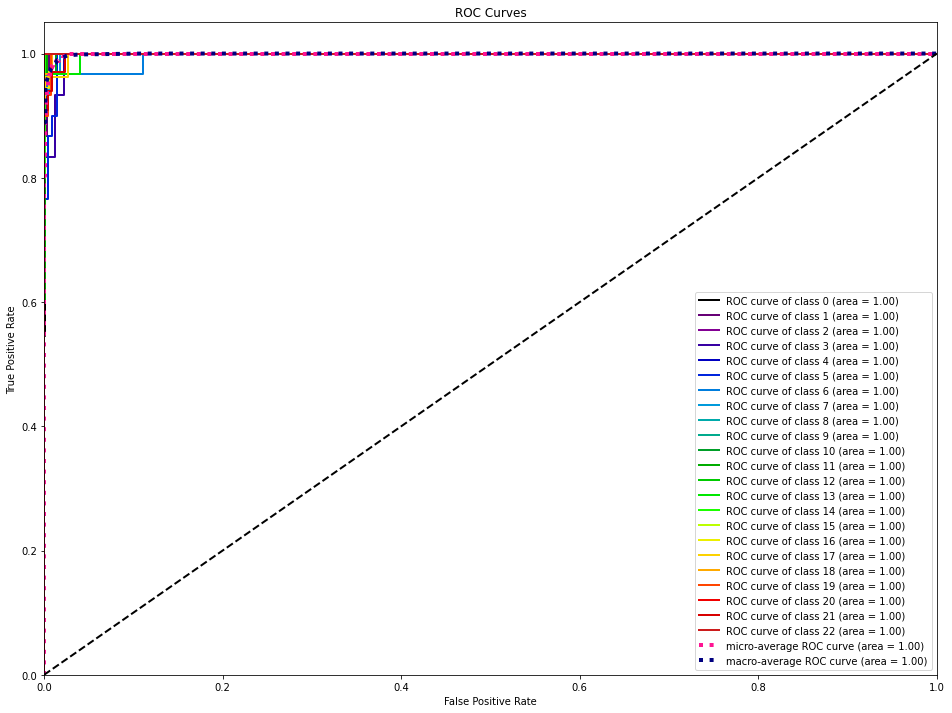

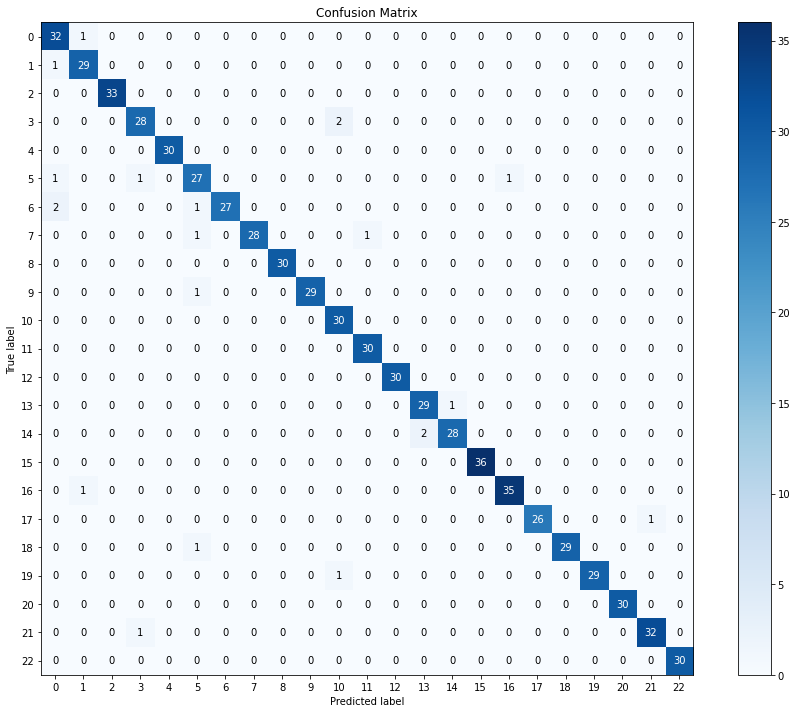

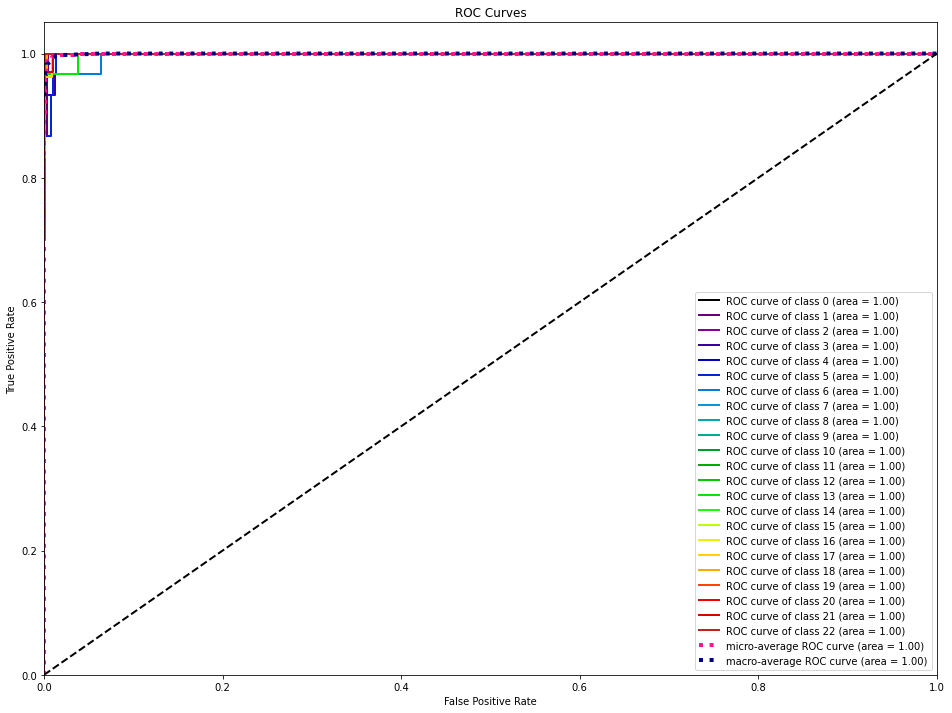

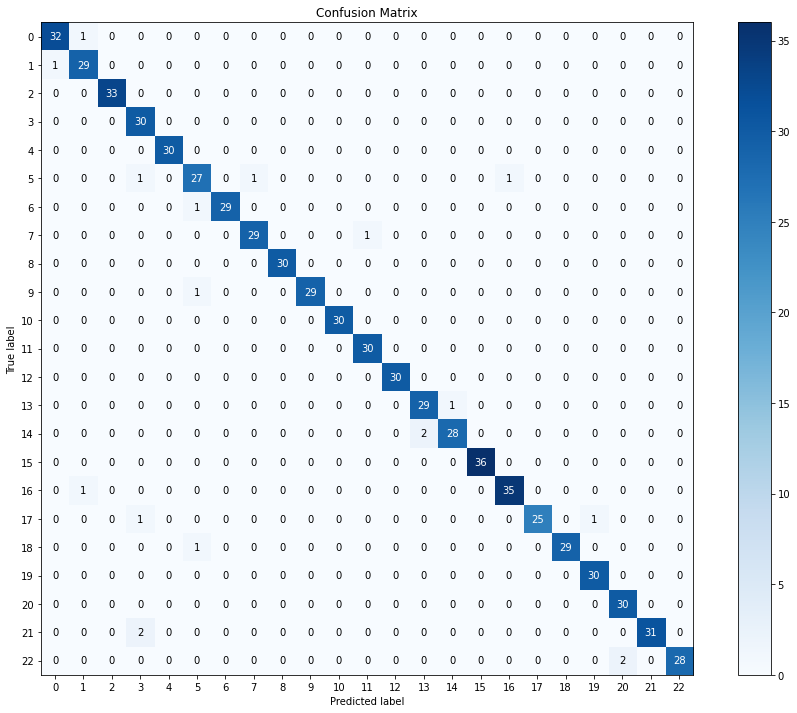

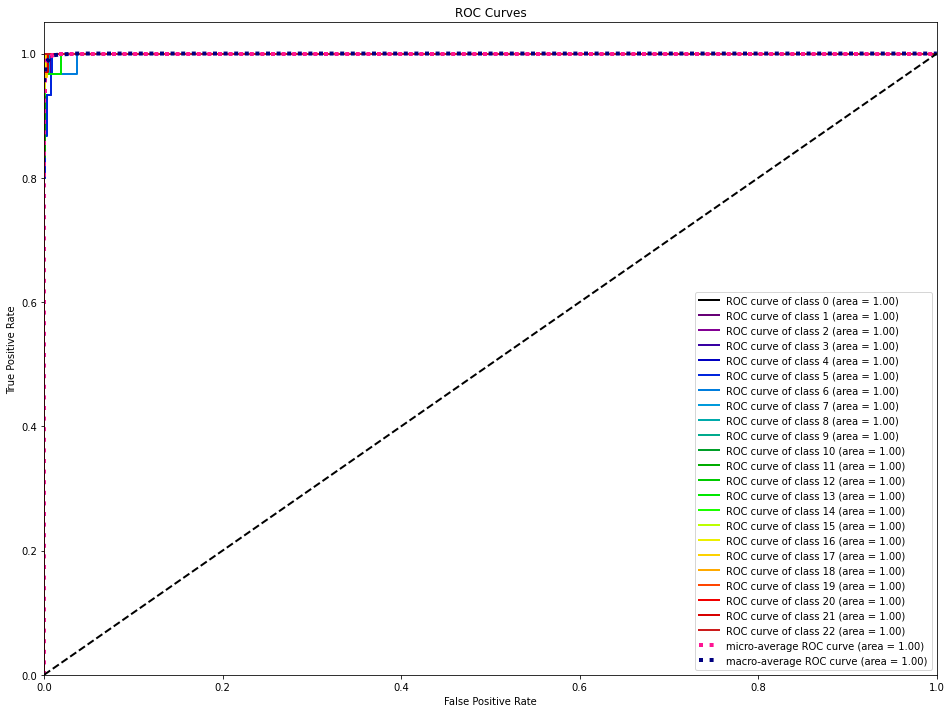

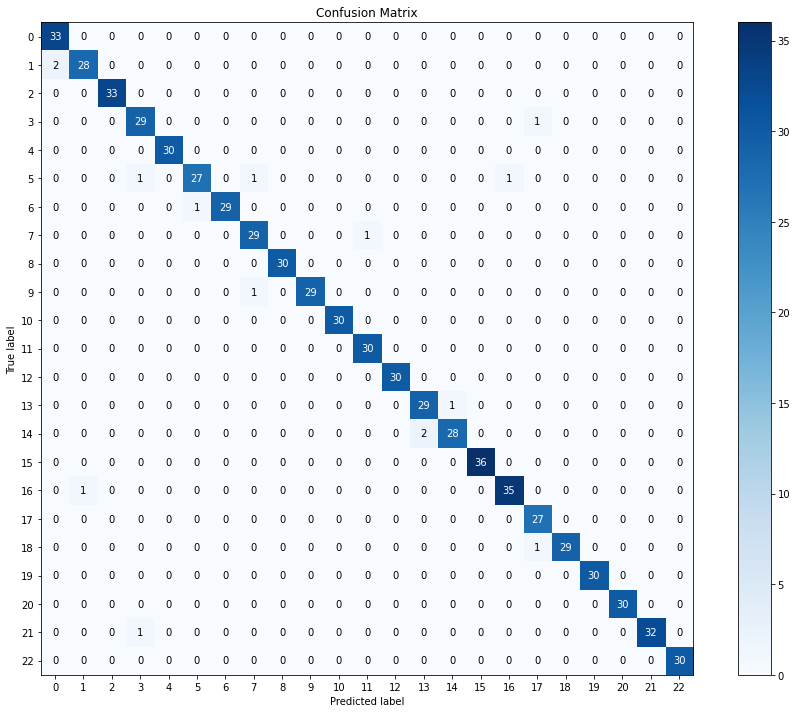

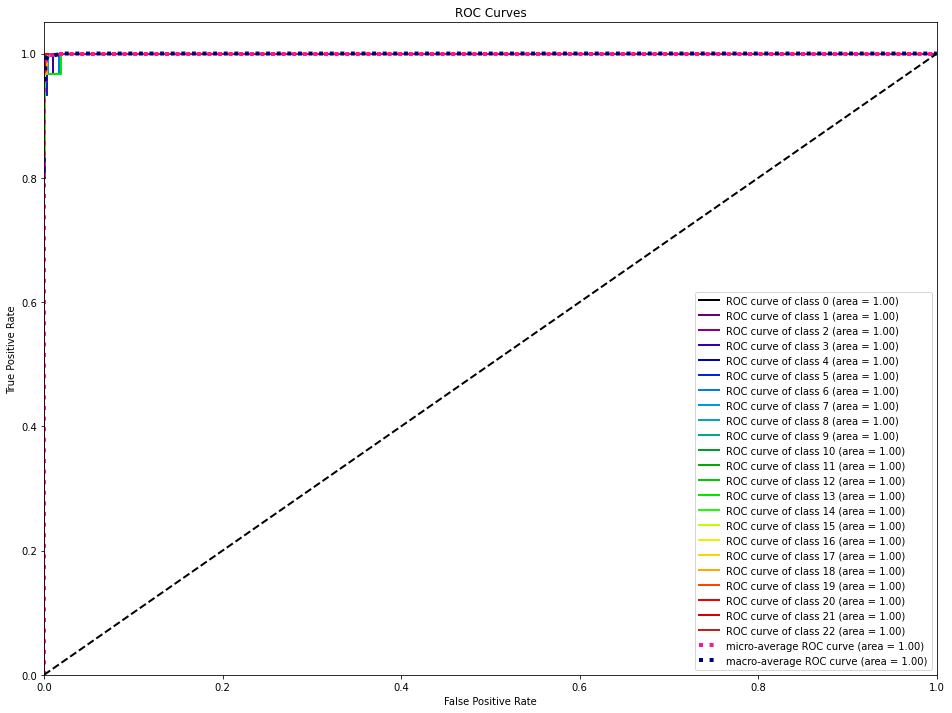

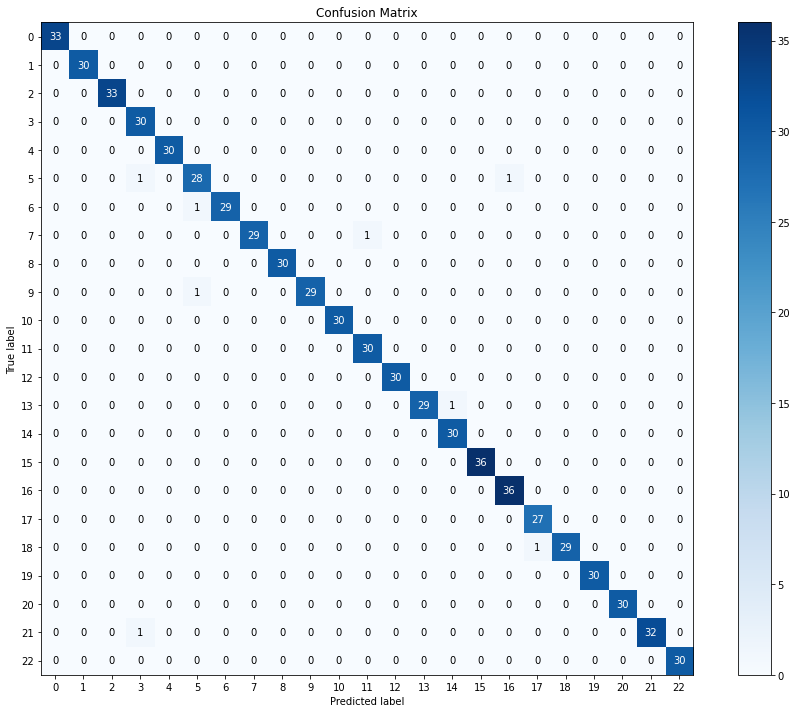

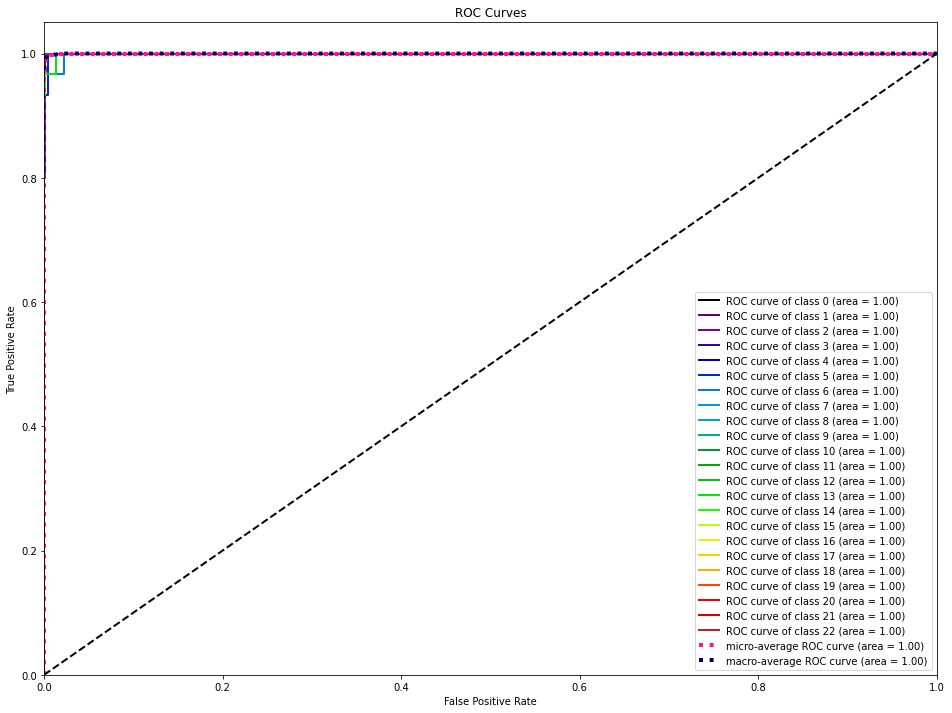

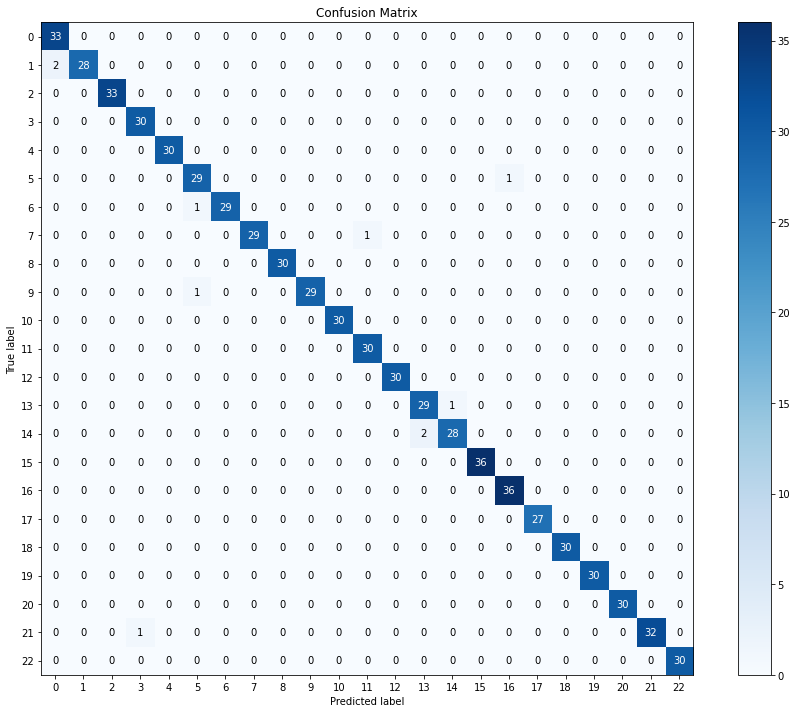

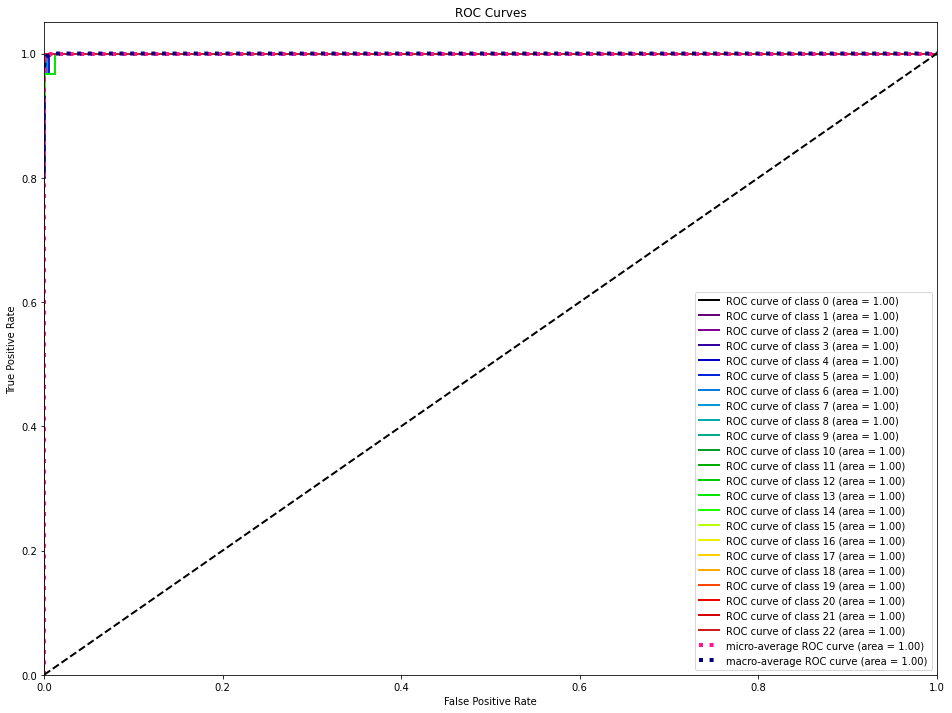

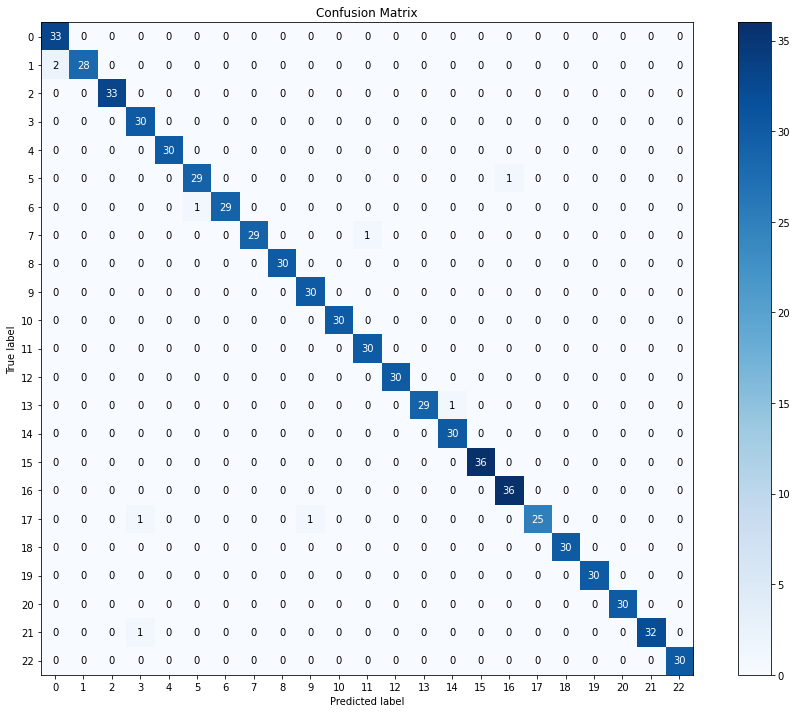

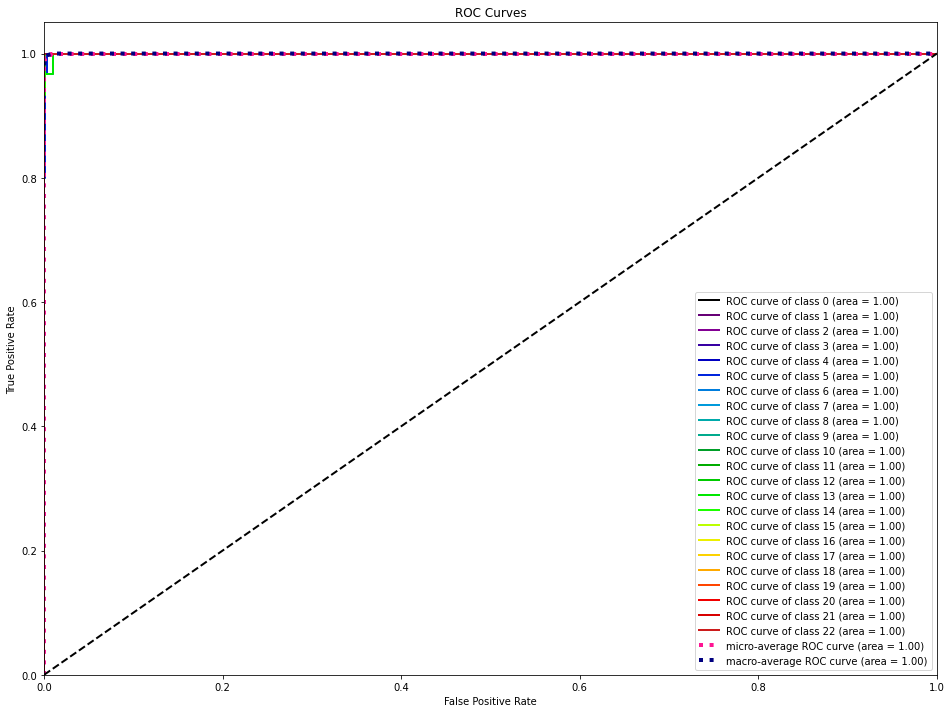

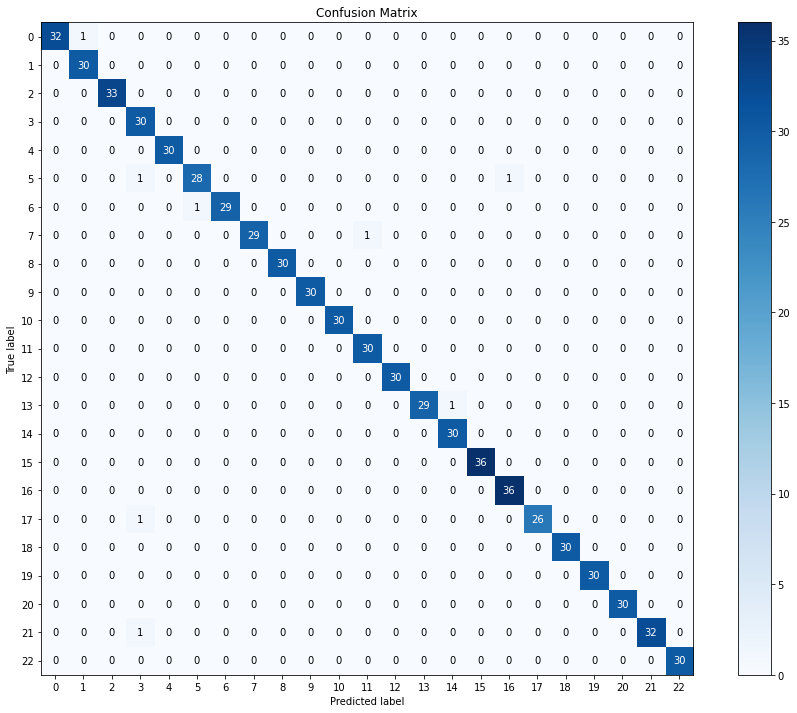

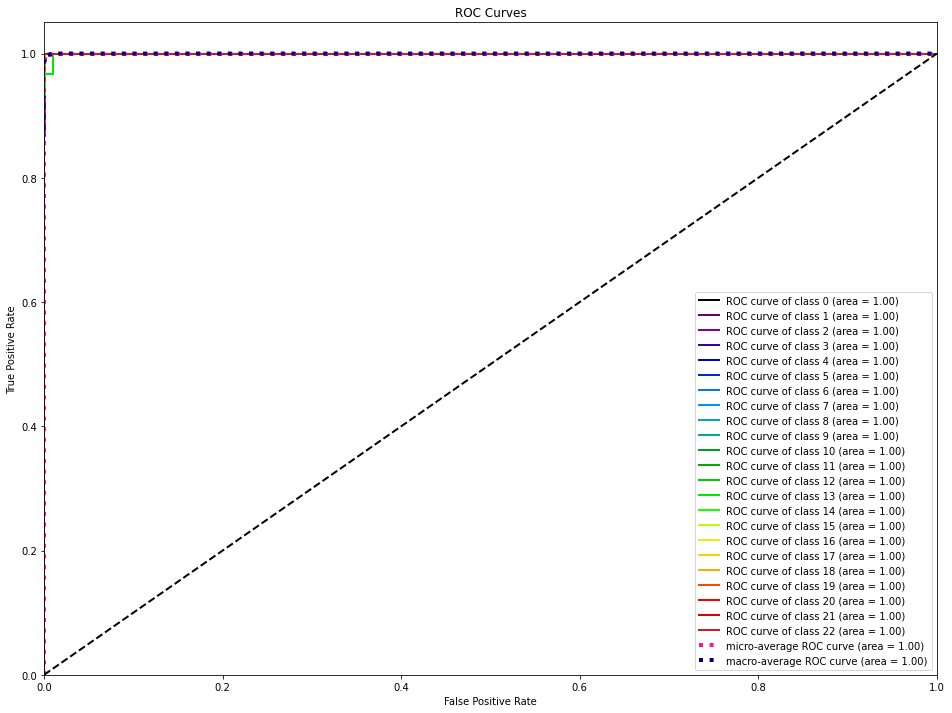

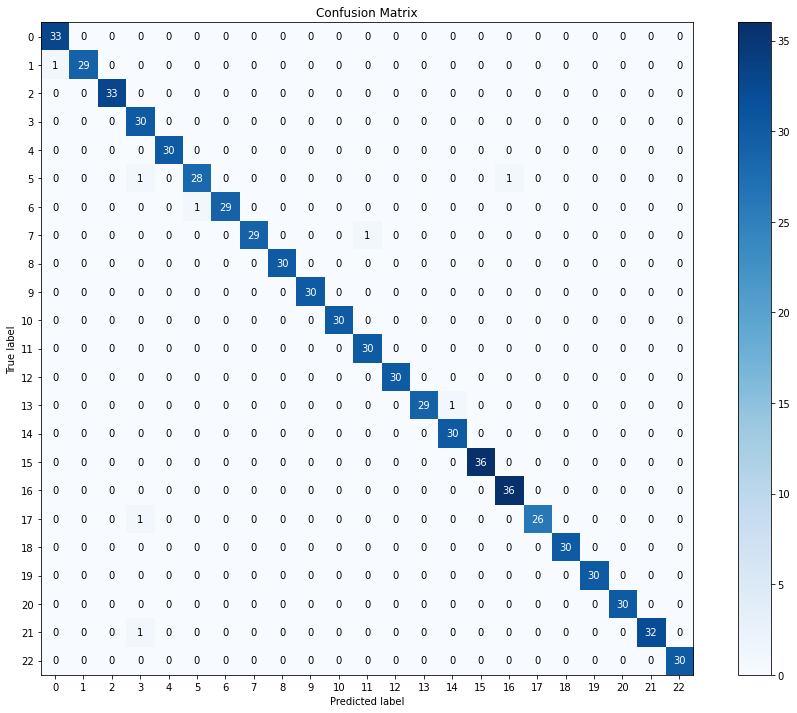

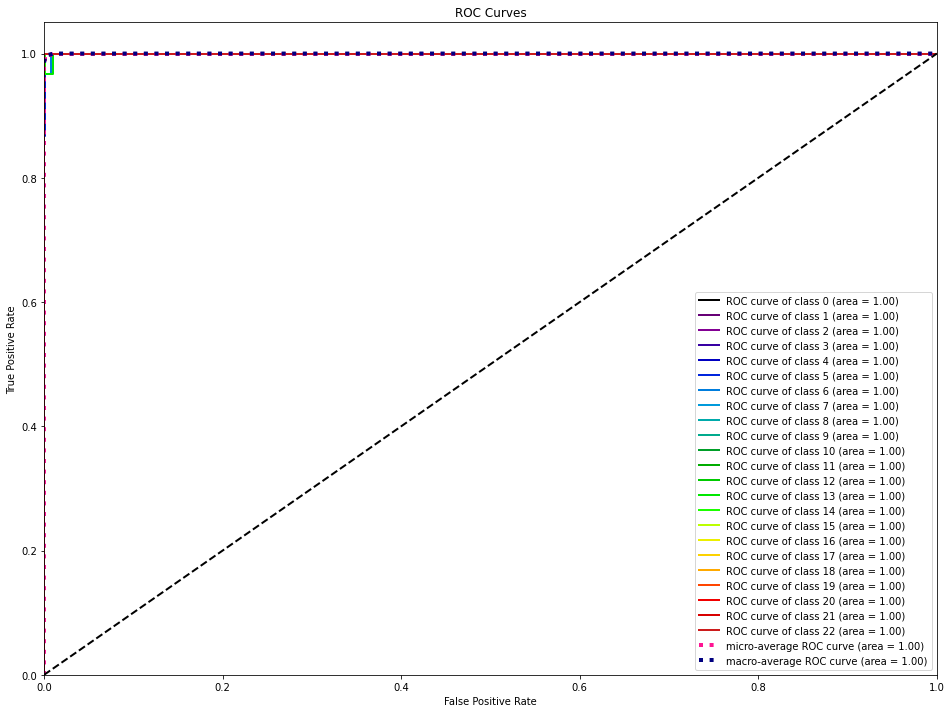

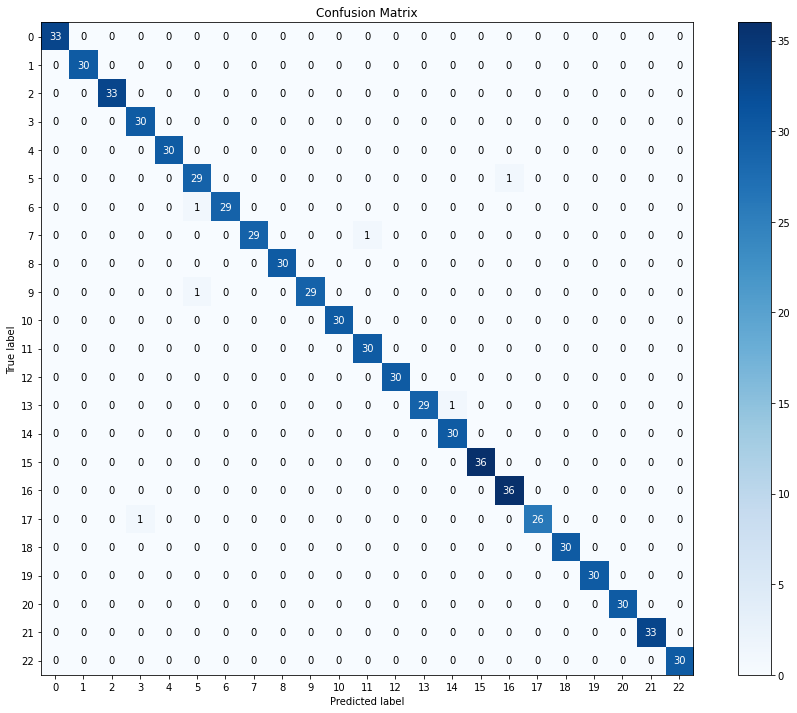

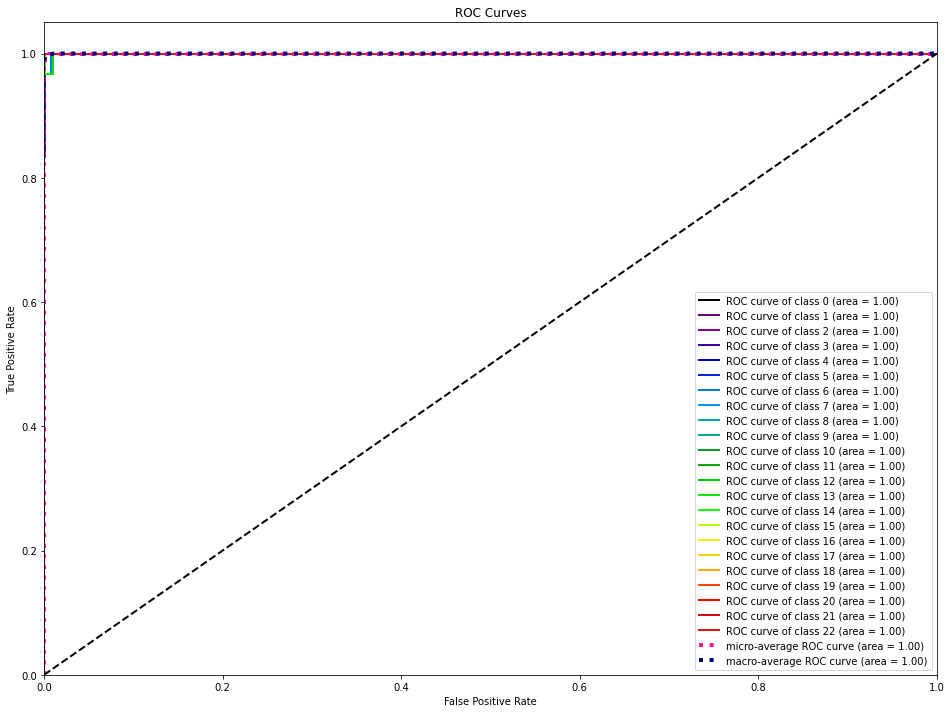

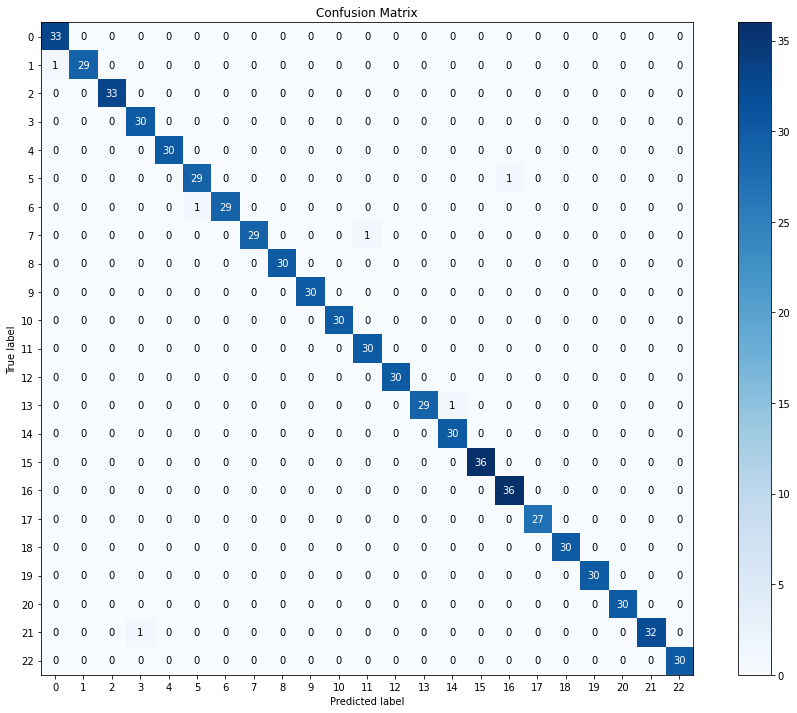

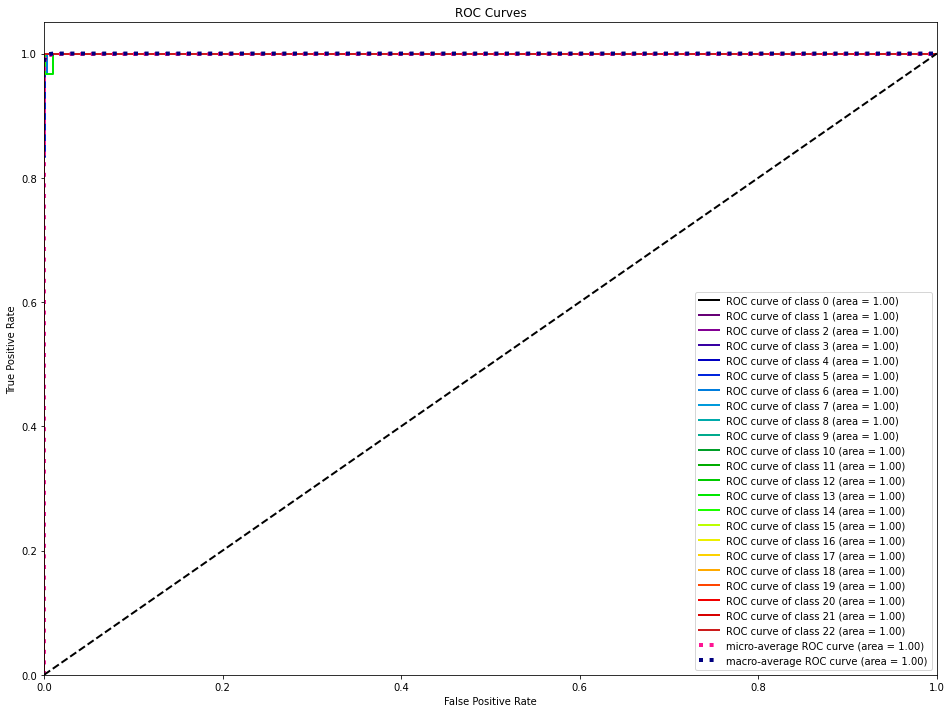

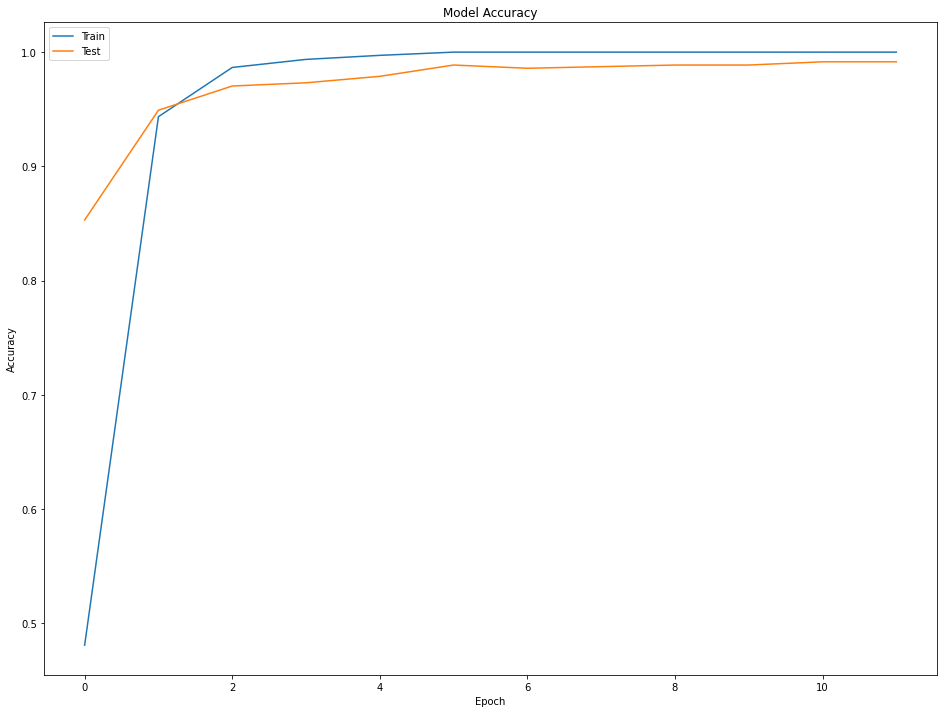

In [24]:
# Mappen von Klassen Namne auf Zahlen
class_dict = {k: v for v, k in enumerate(np.unique(train_class_name))}

# Labels der jeweiligen Bilder umwandeln
train_val    = [class_dict[train_class_name[i]] for i in range(len(train_class_name))]
train_labels = np.asarray(train_val, dtype=int)

test_val    = [class_dict[test_class_name[i]] for i in range(len(test_class_name))]
test_labels = np.asarray(test_val, dtype=int)

# print(train_val)
# print(test_val)

model = MobileNetV2(weights='imagenet')

# Testen der Predictions ohne Transfer Learning. 
# NOTE: Hier wird nur getestet (rein aus Interesse), wie das vortrainierte Netzwerk mit den Kuhbildern umgeht. In den meisten Fällen wird eine Kuh (oder ein Ox) 
#       erkannt, aber nicht immer. Witzigerweise werden einige der Bilder als Dalmatiner klassifiziert. (Auskommentieren, um Ergebnisse zu sehen!)

# predictions = model.predict(train_data)
# for decoded_predictions in decode_predictions(predictions, top=1):
#	for name, desc, score in decoded_predictions:
#		print('- {} ({:.2f}%%)'.format(desc, 100*score))

# Output Layer für die 23 Kühe anlegen
cow_output = Dense(len(class_dict), activation='softmax')
cow_output = cow_output(model.layers[-2].output)

# Neues Model aus dem Input von MobileNetV2 und dem neuen Ausgabelayer erstellen
cow_input = model.input
cow_model = Model(inputs=cow_input, outputs=cow_output)

# Alle Layer bis auf den neuen vom Training ausschließen, damit nur die Gewichte des Ausgabelayers angepasst werden
# TODO: try setting the training for the last 2 layers instead of just the last
for layer in cow_model.layers[:-1]:
	layer.trainable = False

# Kompilieren des neuen Models
cow_model.compile(
	optimizer='adam',
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)

performance_callback = PerformanceVisualizationCallback(
    model=cow_model,
    validation_data=(test_data, test_labels),
    image_dir='performance/'
)

# Trainieren des Models mit vorher angelegten Daten
history = cow_model.fit(x=train_data, 
              y=train_labels, 
              validation_data=(test_data, test_labels),
              callbacks=[performance_callback],
              epochs=12, 
              verbose=2)

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
fig.show()
fig.set_frameon(True)
fig.set_facecolor('white')
fig.savefig('performance/history.png', bbox_inches='tight', transparent=False)
